# PyMC and Universal Samplers

## Part A: `import pymc`

In [1]:
import pymc

- [Introductory Overview of PyMC](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html)
- [Example Gallary](https://www.pymc.io/projects/examples/en/latest/gallery.html)

In [2]:
print(f"Running on PyMC v{pymc.__version__}")

Running on PyMC v5.10.4


In [3]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

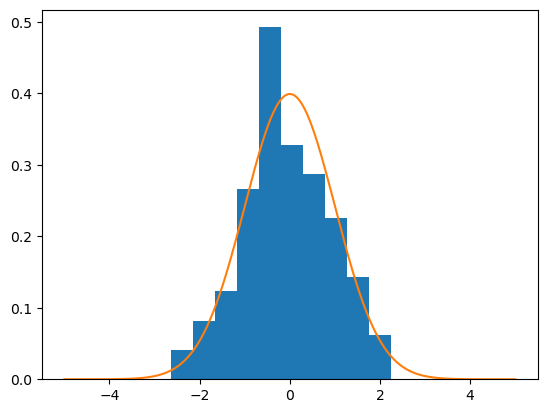

In [4]:
n = 100
true_theta, true_tau = 0,1
data_generating_mechanism = \
stats.norm(loc=true_theta, scale=true_tau**(-0.5))

x = data_generating_mechanism.rvs(size=n)
plt.hist(x, density=True)
x_grid = np.linspace(-5*true_tau**(-0.5),5*true_tau**(-0.5),1000)
plt.plot(x_grid,data_generating_mechanism.pdf(x_grid));


In [5]:
conjugate_normal_gamma = pymc.Model()

with conjugate_normal_gamma:

    # Priors for unknown model parameters
    
    theta0 = 0  # prior belief regarding true_theta
    theta_prior_n = 1  # strength of prior belief as units of data
    # theta_prior_n = tau0/true_tau
    tau0 = theta_prior_n*true_tau  
    theta = pymc.Normal("theta", mu=theta0, sigma=tau0**(-0.5))
    # Compared to scipy.stats
    # loc -> mu
    # scale -> sigma but you can also use tau as below...
    
    tau_SS_prior = 1  # prior belief regarding true_sum_of_squares
    tau_prior_n = 1  # strength of prior belief as units of data
    tau = pymc.Gamma("tau", alpha=tau_prior_n/2, 
                            beta=tau_SS_prior/2)
    # https://en.wikipedia.org/wiki/Gamma_distribution
    # pymc.Gamma?
    # Now it's **rate** (beta) NOT scale

    # Likelihood (sampling distribution) of observations
    x_obs = pymc.Normal("x_obs", mu=theta, tau=tau, observed=x)

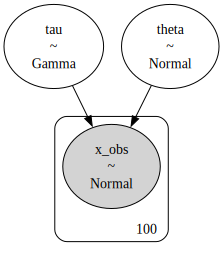

In [6]:
pymc.model_to_graphviz(conjugate_normal_gamma)

In [7]:
m = 10000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## `idata` and `arviz as az`

In [8]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [9]:
idata.posterior

<xarray.Dataset> Size: 400kB
Dimensions:  (chain: 2, draw: 10000)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
Data variables:
    tau      (chain, draw) float64 160kB 1.159 1.075 0.9958 ... 1.207 1.168
    theta    (chain, draw) float64 160kB -0.1467 0.05813 ... -0.1593 -0.157
Attributes:
    created_at:                 2025-02-05T21:49:44.550495+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.10.4
    sampling_time:              5.75824236869812
    tuning_steps:               100

In [10]:
idata.posterior['theta']

<xarray.DataArray 'theta' (chain: 2, draw: 10000)> Size: 160kB
array([[-0.14667909,  0.05812712, -0.01415999, ..., -0.11346271,
        -0.01791356, -0.21572469],
       [-0.03766306, -0.06612753, -0.1001947 , ..., -0.18743766,
        -0.15926288, -0.15701748]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

In [11]:
idata.posterior['tau']

<xarray.DataArray 'tau' (chain: 2, draw: 10000)> Size: 160kB
array([[1.15855291, 1.07483656, 0.99581128, ..., 0.94436359, 1.07909123,
        1.07284545],
       [1.08221095, 0.91821279, 1.00222873, ..., 0.95414521, 1.20683046,
        1.16845702]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

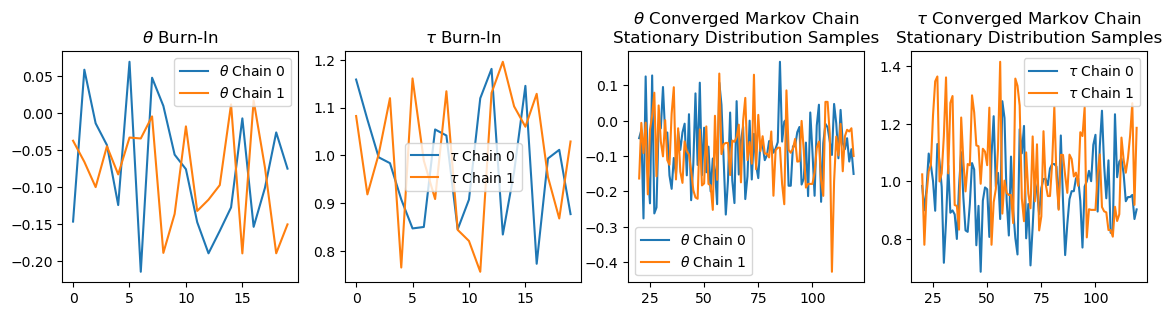

In [12]:
theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape

fig,ax = plt.subplots(1, 4, figsize=(14,3));ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

# pymc.sample(draws=1000, chains=2, tune=100)
# used 100 samples per chain to "tune" and these were
# automatically discarded so `burn` is likely not needed
burn = 20
demo = 120
C = 2
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();  

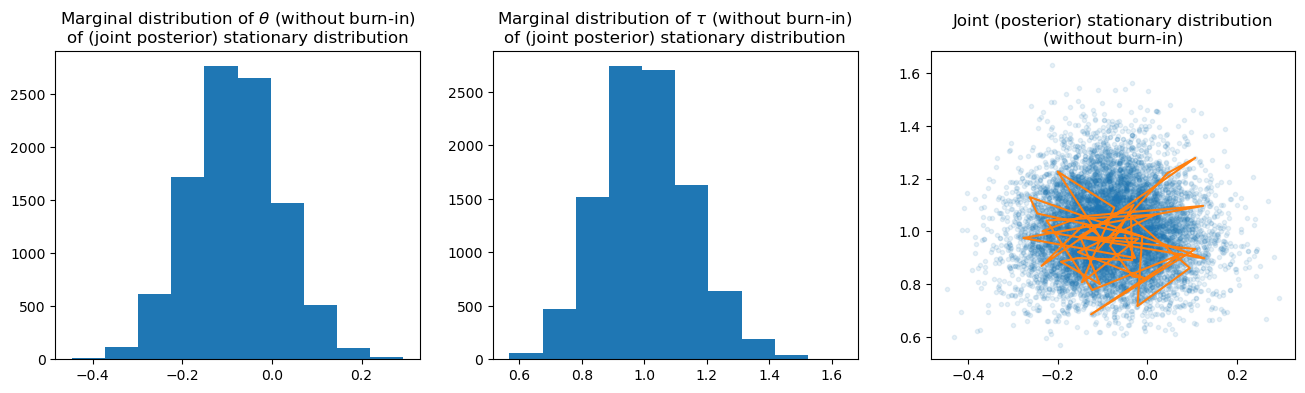

In [13]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

In [14]:
import arviz as az

In [15]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

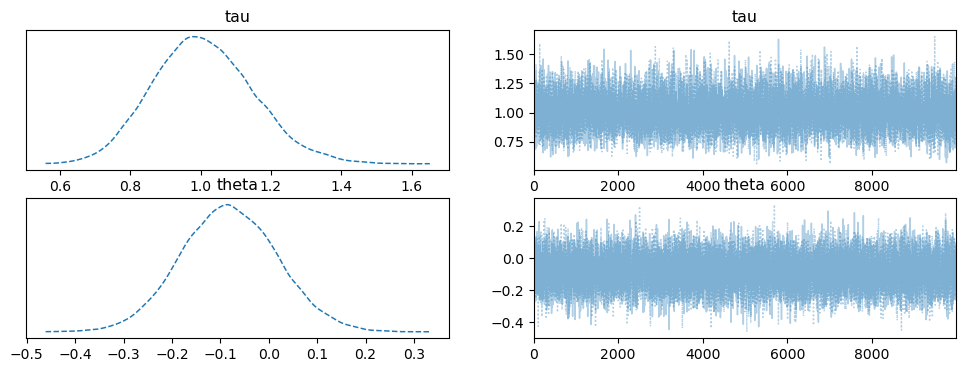

In [16]:
az.plot_trace(idata, combined=True);

In [ ]:
az.plot_trace(idata)
plt.tight_layout()

In [ ]:
m = 1000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape    

In [ ]:
# If the messages below don't show
"""Auto-assigning NUTS sampler...
   Initializing NUTS using jitter+adapt_diag...
   Multiprocess sampling (2 chains in 4 jobs)
   NUTS: [theta, tau] """
# You can see this information by turning on logging
import logging # dir(logging) for available functionality
_log = logging.getLogger("pymc")
#_log.setLevel(logging.NOTSET) # 0
_log.setLevel(logging.INFO) # 20
#_log.setLevel(logging.WARNING) # 30
#_log.setLevel(logging.ERROR) # 40

In [ ]:
az.plot_forest(idata, var_names=["theta", "tau"], 
               combined=False, hdi_prob=0.95, r_hat=True);


## Part B: Posterior inference and diagnostics<br><sub>with `az.summary`</sub>

In [17]:
az.summary(idata, round_to=5)#2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,1.00757,0.14348,0.74248,1.27833,0.00140,0.00099,10479.26550,11053.62731,1.00004
theta,-0.08235,0.09969,-0.26318,0.11162,0.00072,0.00058,19262.59859,14523.69136,1.00018


In [18]:
theta.ravel().shape

(20000,)

### `mean` and `sd`

In [19]:
round_to=5
theta.ravel().mean().round(round_to), tau.ravel().mean().round(round_to)

(-0.08235, 1.00757)

In [20]:
theta.ravel().std().round(round_to), tau.ravel().std().round(round_to)
theta.ravel().std(ddof=1).round(round_to), tau.ravel().std(ddof=1).round(round_to)

(0.09969, 0.14348)

### `hdi_3%` and `hdi_97%`

In [21]:
az.summary(idata, round_to=5)#2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,1.00757,0.14348,0.74248,1.27833,0.00140,0.00099,10479.26550,11053.62731,1.00004
theta,-0.08235,0.09969,-0.26318,0.11162,0.00072,0.00058,19262.59859,14523.69136,1.00018


In [22]:
np.quantile(theta,[0.05,0.95]).round(round_to)

array([-0.24441,  0.08218])

In [23]:
np.quantile(theta,[0.025,0.975]).round(round_to)

array([-0.2746 ,  0.11577])

In [24]:
np.quantile(theta,[0.03,0.97]).round(round_to)

array([-0.26681,  0.10815])

In [26]:
# hdi_3% and hdi_97% is something like
# move interval up or down until the smallest interval is found
np.quantile(theta,[0.02,0.96]).round(round_to)

array([-0.28376,  0.09426])

In [27]:
# so trying to get a bit closer for tau it's someting like
np.quantile(tau,[0.022,0.9622]).round(round_to)

array([0.73744, 1.27454])

### To consider `mcse_mean` and `mcse_sd`...

- [...moments of moments and first order Taylor series approximation](https://mc-stan.org/posterior/reference/mcse_sd.html)

In [28]:
az.summary(idata, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,1.00757,0.14348,0.74248,1.27833,0.00140,0.00099,10479.26550,11053.62731,1.00004
theta,-0.08235,0.09969,-0.26318,0.11162,0.00072,0.00058,19262.59859,14523.69136,1.00018


In [ ]:
az.summary(idata, round_to=5)['sd']['theta']/\
az.summary(idata, round_to=5)['ess_bulk']['theta']**0.5

In [ ]:
az.summary(idata, round_to=5)['sd']['tau']/\
(az.summary(idata, round_to=5)['ess_bulk']['tau']+0)**0.5

In [ ]:
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']


In [ ]:
# this estimates y which is the variance
((theta.ravel()-theta.ravel().mean())**2).mean()
theta.ravel().var()
# square root of this estimates standard deviation
# s = sqrt(y)

# this estimates variance of y above estimator
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']

# by the delta method 
# https://stats.stackexchange.com/questions/491845/how-is-delta-method-used-here-in-approximating-the-square-root-of-a-normal-rando
# var(S) = (1/sqrt(E[Y]))**2 * Var(Y)

((1/theta.ravel().var())*\
 ((theta.ravel()-theta.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['theta'])**0.5

# So it's not quite right...but then again it's maybe not exactly
# https://mc-stan.org/posterior/reference/mcse_sd.html
# "Compute the Monte Carlo standard error for the 
#  standard deviation (SD) of a single variable 
#  without assuming normality using moments of moments 
#  and first order Taylor series approximation 
#  (Kenney and Keeping, 1951, p. 141)."

In [ ]:
((1/tau.ravel().var())*\
 ((tau.ravel()-tau.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['tau'])**0.5

In [ ]:
az.summary(idata, round_to=5)

### We must first consider `bulk_tail` and `ess_tail`...

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


In [ ]:
theta_in_tail = \
(theta<=np.quantile(theta.ravel(),0.05))#+\
(theta>=np.quantile(theta.ravel(),0.95))
print(theta_in_tail.sum()/(2*m))
theta_in_tail

In [ ]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta_in_tail[c,:-t_plus_k], 
                    theta_in_tail[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[5,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [ ]:
autocorrelations[:,:10]

In [ ]:
tau_in_tail = \
(tau<=np.quantile(tau.ravel(),0.05))+\
(tau>=np.quantile(tau.ravel(),0.95))
print(tau_in_tail.sum()/(2*m))
tau_in_tail

In [ ]:
m = 1000
K = 30
autocorrelations = np.ones((2,m-1))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau_in_tail[c,:-t_plus_k], 
                    tau_in_tail[c,t_plus_k:])[0,1]
        
for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[8,6]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())

In [ ]:
autocorrelations[:,:20]

In [ ]:
az.summary(idata, round_to=5)

#### Reminder 

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


In [ ]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta[c,:-t_plus_k], 
                    theta[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[3,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [ ]:
autocorrelations[:,:10]

In [ ]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau[c,:-t_plus_k], 
                    tau[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[5,7]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [ ]:
autocorrelations[:,:10]

In [ ]:
az.summary(idata, round_to=5)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(theta.ravel()[:-1], theta.ravel()[1:], '.', alpha=0.25)
ax[1].plot(tau.ravel()[:-1], tau.ravel()[1:], '.', alpha=0.25);

## Part C: R-hat and "energy"

A lack of insufficient "mixing" (agreement) between chains is diagnosed by comparing within and between chain variability. This is done by **checking if the split-$\hat R$ statistic is greater than** $\mathbf{1.05}$. is deemed sufficient when . This is suggestive (but not proof) that the the **Markov chains** have converged to their **stationary distributions**.

> Thus far above we have avoided the notion of "split" chains. Split chains must be considered to ensure that a "drifting chain" does not accidentally pass the $\hat R$ check. Thus the split-$\hat R$ statistic.


$\Large \text{Split-}\hat R  = \sqrt{\frac{\frac{N-1}{N}W +  \overbrace{\frac{1}{M-1}\sum_{m=1}^M (\overline{\theta^{(m,\cdot)}} - \overline{\theta^{(\cdot,\cdot)}})^2}^{\text{between chain variance}} }{\underbrace{\frac{1}{M}\sum_{m=1}^M \frac{1}{N-1}\sum_{n=1}^N (\theta^{(m,n)} - \overline{\theta^{(m,\cdot)}})^2}_{\text{$W$: within chain variance}}} } $ 

In [ ]:
az.summary(idata, round_to=5)

In [ ]:
az.plot_trace(idata)
plt.tight_layout()

### Energy

Another diagnostic that sometimes applies is based on the so-called [energy](https://discourse.mc-stan.org/t/help-understanding-bfmi-interpreting-bfmi-1/28554). The exact meaning of "energy" will be discussed next class but for now suffice it to say that when the "Energy transition" fails to dominate the "Marginal energy" the sampler is experiencing a computational bottleneck.


In [ ]:
az.plot_energy(idata);

## Part D: Samplers


In [31]:
pymc.sample?

Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [theta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,1.00,0.14,0.74,1.28,0.0,0.0,1976.98,2345.48,1.0
theta,-0.08,0.10,-0.26,0.11,0.0,0.0,2183.92,2514.48,1.0


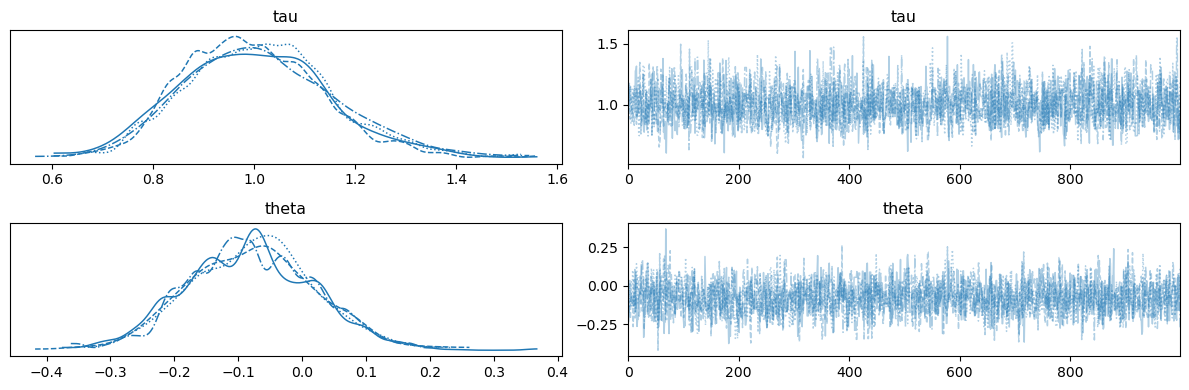

In [32]:
with conjugate_normal_gamma:
    HMC = pymc.HamiltonianMC()
    idata_HMC = pymc.sample(chains=4, step=HMC)
    
display(az.summary(idata_HMC, round_to=2))
az.plot_trace(idata_HMC)
plt.tight_layout()    

In [33]:
# theta rejection rates
(idata_HMC.posterior.theta.values[:,:-1]==idata_HMC.posterior.theta.values[:,1:]).mean(axis=1)

array([0.25125125, 0.23323323, 0.31531532, 0.35735736])

In [34]:
# tau rejection rates
(idata_HMC.posterior.tau.values[:,:-1]==idata_HMC.posterior.tau.values[:,1:]).mean(axis=1)

array([0.25125125, 0.23323323, 0.31531532, 0.35735736])

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_HMC.posterior.theta.values.ravel()[:-1], 
           idata_HMC.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_HMC.posterior.tau.values.ravel()[:-1], 
           idata_HMC.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

In [ ]:
with conjugate_normal_gamma:
    idata = pymc.sample(chains=4, target_accept=0.9)
    
display(az.summary(idata, round_to=2))
az.plot_trace(idata)
plt.tight_layout()    

In [ ]:
import pandas as pd
display(pd.DataFrame(idata.sample_stats.acceptance_rate))
# rejection rates
1-idata.sample_stats.acceptance_rate.values.mean(axis=1)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata.posterior.theta.values.ravel()[:-1], 
           idata.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata.posterior.tau.values.ravel()[:-1], 
           idata.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

In [ ]:
with conjugate_normal_gamma:
    sampler = pymc.Slice()
    idata_slice = pymc.sample(step=sampler)

display(az.summary(idata_slice, round_to=2))
az.plot_trace(idata_slice)
plt.tight_layout()    

In [ ]:
# theta rejection rates
(idata_slice.posterior.theta.values[:,:-1]==idata_slice.posterior.theta.values[:,1:]).mean(axis=1)

In [ ]:
# tau rejection rates
(idata_slice.posterior.tau.values[:,:-1]==idata_slice.posterior.tau.values[:,1:]).mean(axis=1)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_slice.posterior.theta.values.ravel()[:-1], 
           idata_slice.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_slice.posterior.tau.values.ravel()[:-1], 
           idata_slice.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

In [ ]:
with conjugate_normal_gamma:
    MHv1 = pymc.Metropolis(S=np.ones(1), scaling=1, tune=False)
    idata_MHv1 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv1)

display(az.summary(idata_MHv1, round_to=2))
az.plot_trace(idata_MHv1)
plt.tight_layout()    

In [ ]:
# theta rejection rates
(idata_MHv1.posterior.theta.values[:,:-1]==idata_MHv1.posterior.theta.values[:,1:]).mean(axis=1)

In [ ]:
# tau rejection rates
(idata_MHv1.posterior.tau.values[:,:-1]==idata_MHv1.posterior.tau.values[:,1:]).mean(axis=1)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv1.posterior.theta.values.ravel()[:-1], 
           idata_MHv1.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv1.posterior.tau.values.ravel()[:-1], 
           idata_MHv1.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

In [ ]:
with conjugate_normal_gamma:
    MHv2 = pymc.Metropolis(S=np.ones(1), scaling=0.1, tune=False)
    idata_MHv2 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv2)

display(az.summary(idata_MHv2, round_to=2))
az.plot_trace(idata_MHv2)
plt.tight_layout()    

In [ ]:
# theta rejection rates
(idata_MHv2.posterior.theta.values[:,:-1]==idata_MHv2.posterior.theta.values[:,1:]).mean(axis=1)

In [ ]:
# tau rejection rates
(idata_MHv2.posterior.tau.values[:,:-1]==idata_MHv2.posterior.tau.values[:,1:]).mean(axis=1)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv2.posterior.theta.values.ravel()[:-1], 
           idata_MHv2.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv2.posterior.tau.values.ravel()[:-1], 
           idata_MHv2.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

## Week 5 Homework

---

### Q1: Questions about PyMC...

Complete this formatted markdown listing of the contents of "PyMC Example Gallery". *Include links and your favorite image (right click and "copy image address") from each page.*


#### Introductory

- [General Overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html)
- [Simple Linear Regression](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html)
- [General API quickstart](https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/docs/en/stable/_images/ac30f30b2297ec4f2bb798b4f28d2cbba2d0502dbaae4a5f78fdd5cccacda517.svg)|<img src="https://www.pymc.io/projects/docs/en/stable/_images/a8276d1222c43c061dbfff6fa3ff3af15b86038fd7d1e204c429ae3714ea1a20.png"  width="500"/>|![](https://www.pymc.io/projects/examples/en/latest/_images/434538d8660bf2399ebf9df11cbd2b7cec62d8abafc588da625315074b628118.png)|

#### Library Fundamentals

- Distribution Dimensionality
- PyMC and PyTensor
- Using Data Containers

| | | |
|-|-|-||![logo.png]()|
|1|2|3|


#### Image Gallery!!


| General Overview | Simple Linear Regression | General API quickstart |
|-|-|-|
| <img src="https://www.pymc.io/projects/docs/en/stable/_images/e4d51c3aa30152870ac3e856061f670d5512689f02bc26426b537e1ce695e010.png" /> | <img src="https://www.pymc.io/projects/docs/en/stable/_images/ad02eabf1d3154d899455a5078259474f2133ba633129b2cb25c831284723dc7.png" /> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/74df7081244e2ea0377564e6ded756f11702b7ab07a138ebbf3fb1a5d14d81ac.png" /> |

| Distribution Dimensionality | PyMC and PyTensor | Using Data Containers |
|-|-|-|
| <img src="https://www.pymc.io/projects/docs/en/stable/_images/acfb0536de4db53baddb8a6d632d6efdc65c01eedeee1a90b7b1e1dd45db4c16.svg" /> | <img src="https://www.pymc.io/projects/docs/en/stable/_images/259ee23b8d61a67f2fc50d8316c9ecd80fa3b1053d0472027316d04df78b2cda.png" /> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/93bd28cbe92a4ebcd2ac5f2701fc0f1d1708da944cd68ec9b96f26b1acef03c0.svg" /> |

| Prior and Posterior Predictive Checks | Model Comparison | Updating Priors |
|-|-|-|
| <img src="https://www.pymc.io/projects/docs/en/stable/_images/ff23516dbee6a363a9666322f96566d04330e625e30db70966f6d9dd677d6f8d.png" /> | <img src="https://www.pymc.io/projects/docs/en/stable/_images/69bd250de55dfb612954797a0838bf15f33d8001365fbede3ae19d1656a495da.png" /> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/869b5446681e715a669de9b0305a3a1bbaf42c194354efa44542f781118022ae.png" /> |

| Automatic marginalization | How to debug a model | How to wrap a JAX function |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/36a3357f89d21ad98e89a8eef3179f83d6897f347714629d8ac8a85bd7100ad3.png" /> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/cd8d49dd3519e25c0ec2d3ef30a0816fe9c3f7708d9eda15d157590da6ca27b5.svg" /> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/810705521c6d764cc52621beb88fb0f1160e1a92c804d6708c7c4f84aa34a535.png" /> |

| Splines | Bayesian copula estimation | Using ModelBuilder class |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/fc05f4904f9bc747ae16a7c7037f87b7dc39a480a2a24f0cff56f2ab9f1b9470.png" /> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/copula_schematic.png" /> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/bbc4da85106ec9c236813f170272c9b249e0a8af0911c428cddbf54bb0752c74.png" /> |

| Using "black box" likelihood | LKJ Cholesky Covariance Priors | Bayesian Missing Data Imputation |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/64c6c9c70b40b4cf651b5ad2b2b1b84a1e7e93a5ed67fac4355a38fcecf47024.png" /> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/f859e4ca959a1c0fc8f886a6752ef8317cff5016e94dc17a7c1cc6ac2cd9535f.png" /> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/4651aee3b14cc8fcb4f416403736e3ecb5f7f8ce1171367a38f6c44a02888f86.png" /> |

| GLM: Robust Linear Regression | GLM-ordinal-features | Out-Of-Sample Predictions |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/cca03e23e9627b2fb5f4156cb11fa372d2c3f72389827aa6cfb4087cee0fb16e.png" /> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/6ef5afd4f6618d3c0ed365a070e3a9ddea28b7ef7be11e7e131885f831f4ea37.png" /> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/506205391b7910fb0cf250bf3397ddc842c5bb2f2650e089ebec9d542f49d3fa.png" /> |

| Bayesian regression with truncated data | Binomial regression | GLM: Negative Binomial Regression |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/60c8fe5e1caad4c617d1a2c0f48e1603df6b2a5f3c0c777e23c2e298ee0ba3b0.png" /> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/47b2df508c92dc27eed40a33b0d251d3b893b2509296aaf89312352c4cbf31c5.png" /> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/26e650782d73f95310b3fda053366e4f2a9df307cc35e9ed09f3a2fecc1ed06d.png" /> |

| Hierarchical Binomial Model | Multilevel Modeling | GLM-missing-values |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/02876264b478027ad5229df6fd2030ad6b920fc7092a6c1802da60315485d3f5.png" /> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/e9b00f89d8e37f6d896cf10229191d56b5f7d59ff24bcf057d6d2179eaf2408a.png" /> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/913658f33469c28d58598eeadec2fd6d0f36d5be40dd0d554e534a0cb83d48fc.png" /> |


| Regression Models with Ordered Categorical Outcomes | GLM: Poisson Regression | Discrete Choice and Random Utility Models |
|-----------------------------------------------------|-------------------------|-------------------------------------------|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/6928fd059a3b1cdf8ed43348345562fecd7f39a070cfb94d5db76b2345bc99fa.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/8d70edc186902abbd997ed8155b0807406213a2113a01aff27e3e638b83321eb.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/cdb7f44f2cfe84e2cc9a8e023c6db347f18f239b21ab8707d0b0c32520fd2c4f.svg" width="200"> |

| GLM: Model Selection | GLM: Robust Regression using Custom Likelihood for Outlier Classification | Rolling Regression |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/2abb4b985087a1a8d5f8dfa5b485b34f0134adcceb8cccb3fc9dc0f31ada9047.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/2f5bb1629ac3be1ecc2b35fc544b64a20ee1b7aa236ca42498440805f6ce8fc3.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/6527831dd88c242e288d444e294f895c0a50eb792a59369a79e32f9290e5c959.png" width="200"> |

| Confirmatory Factor Analysis and Structural Equation Models in Psychometrics | Hierarchical Partial Pooling | NBA Foul Analysis with Item Response Theory |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/aebe547ee33a40d30f0b8eee41e262900255ed6a7c431ab65a9927b9e13d1573.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/ebc23400283c5ac276dcac1cb83402a474a679bf3963131b9f20349b2c052dea.svg"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/4abeabe9deb44218a9e6d73a842a022ad50fabe0b589f95a58382542eb8c418d.svg"> |

| Bayesian Estimation Supersedes the T-Test | A Hierarchical model for Rugby prediction | Estimating parameters of a distribution from awkwardly binned data |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/073035d65700ed87439b543ebee2d98e340346030646fed769fb9ec5d135f21f.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/57717864299d85cf1955cf3751e75053d89e5663ae2d964ed7ac5726e92a14e7.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/gates_labs_logos.png" width="200"> |

| Factor analysis | Probabilistic Matrix Factorization for Making Personalized Recommendations | Reliability Statistics and Predictive Calibration |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/d3902baec3a16548e994f270bd575d058f63b0919d3aad6bc4b5ab68e650e06d.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/8fcc5a578bcc8708b918dcd0daf99848a665caf1c75bd49ec47df4a55097dd2c.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/c95e8d11d0f6644ec4cb69424b5b3445a79e8bd95fd6c0e1621beb65579231ec.png" width="200"> |

bruh scott is a psychopath
| Generalized Extreme Value Distribution | Model building and expansion for golf putting | Fitting a Reinforcement Learning Model to Behavioral Data with PyMC |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/2c12067916bf68198da5cc8bce60389002195f6abf98201676a0b633dc50696e.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/11c6eb00a2a40c3a65c217b25d41a1f3eb9113849bfbc261e9fb25a32ce57ab4.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/995a216d36052c936298cbb1c1713ab15b14e75aa36c140b1047ad3ef385902f.png" width="200"> |

| Simpson’s paradox | Interrupted time series analysis | Regression discontinuity design analysis |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/556007bb19d7e59adda7f74341718f19e393d830f264f18bf0f1dd60c0477781.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/DAG_interrupted_time_series.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/regression_discontinuity.png" width="200"> |

| Interventional distributions and graph mutation with the do-operator | Bayesian Non-parametric Causal Inference | Bayesian mediation analysis |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/e806743b0f56d604960981028daf1a965d648b05d3638438842820a085dcd323.svg" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/481ea8629033879273d38feac223db9e2bdcdcba02aa881d26bba000a015768f.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/mediation.png" width="200"> |

| Counterfactual inference: calculating excess deaths due to COVID-19 | Introduction to Bayesian A/B Testing | Difference in differences |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/6801a496bcbc6c8599a92797e7cae13b1c2e6d03e7ab8cdd479feb7c8f5b76f8.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/df45924e1e38a6f758e57bc367e572f0b3f635b79ce5a2a9c9c7bcd3b0dbed07.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/DAG_difference_in_differences.png" width="200"> |

| Bayesian moderation analysis | Mean and Covariance Functions | Student-t Process |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/moderation_figure.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/b32dad0edc3b59a6dc6f0da44044b002c11ab9c4e4995b8158637bd766cfad51.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/d2259dbccd843cf921d8959d7935b2dea30c5e4bc73e0c4dd5a237ce6c12b49d.png" width="200"> |

| Heteroskedastic Gaussian Processes | Gaussian Processes: Latent Variable Implementation | Sparse Approximations |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/e232e7d9a039540fb24633a7463866eeab947212b87af65dc9535f55a659c463.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/39603df4f63e88e15dfca57f1eaf6f6aa6385cc08c9e8de8fce0ae99d7ae2162.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/546ae74569c62ee02c96a2605a5b003d0d8df657e30e05f5f0e88c758621c845.png" width="200"> |

| Gaussian Processes using numpy kernel | Kronecker Structured Covariances | Example: Mauna Loa CO₂ continued |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/b3e0033e0eb50e17e785e6a6e73ad21372b0c8dfc1ff73a86e34e9dd17e75f28.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/9435fadf9974988d30272358b4362f3668eaf3d471533a2c5a524717d68ce709.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/c97bb5d41650ef854ebcdc4088fda9f8bd76287973bc2d9951a0f5b6320aafe7.png" width="200"> |

| Gaussian Process for CO₂ at Mauna Loa | Gaussian Processes: HSGP Reference & First Steps | Baby Births Modelling with HSGPs |
|-|-|-|
| <img src="http://sites.gsu.edu/geog1112/files/2014/07/MaunaLoaObservatory_small-2g29jvt.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/1b60fee59767da2f31bbbc437e1c4a5ef4a18065d3c4b6e0bd3fe5d2948523e6.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/dac71b44330f1844173b31a6e5886c3f05f44a7f8351d4bef7766a6dc0e5fd4a.png" width="200"> |

| Marginal Likelihood Implementation | Multi-output Gaussian Processes: Coregionalization models using Hadamard product | GP-Circular |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/2447e8ebbc842686109ae1c94a562490c64513eb6923e57e310fd86563d08d66.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/332521cd6ef8034362d2ef31059c06f5fec0b11b4908dae6091530fc5c7e79f4.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/6d6b411075905d18c7dd9d8a10c79a3a2e2b08203af2daaa4b1f31b355210963.png" width="200"> |

| Modeling spatial point patterns with a marked log-Gaussian Cox process | Gaussian Processes: HSGP Advanced Usage | Gaussian Process (GP) smoothing |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/b6c86a8daa0f88300d9775ace3f5d5908f43487ad9d6cd5418669d807bb91e09.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/649443f0ecb1ba943c4a8897aff5478de8d8cfa0717c9761e3a02de935961727.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/bcf3542bff1b658eec45146edf814b849e52f9a0b49960452634bab68e7242fa.png" width="200"> |

| Longitudinal Models of Change | Forecasting with Structural AR Timeseries | Analysis of An AR(1) Model in PyMC |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/cb51b79da3d2ea65a74632f35d3f6fc34ece85c010e19f4603eee7e16a6809fd.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/a72e7a83bd44131c4c544f52c3de3fb4df7aaf7e9b41e35f5981c9868c69b765.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/58d7f2f82cfb880f1711815ffa168839d405b5c9e380a1eeafe1ba3f5995746c.png" width="200"> |

| Stochastic Volatility model | Time Series Models Derived From a Generative Graph | Bayesian Vector Autoregressive Models |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/6390028c025e1d66c40374fc3238fd8454cf661cd30a07a7e43fe34dc1cae992.png" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/42c93f0c8b71ae2145aab13ec45149fa83763c2416e282d54eefe36f2c4532ef.svg" width="200"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/ecc3bd5333e15cb66600373124e070d5a3e3bc9eeaf273614597721ef6ea9aa9.png" width="200"> |


| Air passengers - Prophet-like model | Multivariate Gaussian Random Walk | Inferring parameters of SDEs using a Euler-Maruyama scheme |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/9fa4b9c96f9f5f55740819d4b25db74ca0a8da4a40aab42c50e364b17ea2d31a.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/6679ddc6c70c248a6c3376f657a2fb64769d3d4e11c73e52fff48014f1d85de8.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/346da134c479657a572ddadb6fca97098efe05fbd219404d0aa1d7f4297dd575.png"> |

| The Besag-York-Mollie Model for Spatial Data | The prevalence of malaria in the Gambia | Conditional Autoregressive (CAR) Models for Spatial Data |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/f9978a554480ea0aa2fb3ab3d68855b1bc7fd0b0956807394252b4c7d84a3b93.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/9a3d6c1d8ed47be69f1b3078ee37ca120cd095b11677decc178011487d3dfb3f.svg"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/b0c1efdbaa4abe2e3e02f1fbe1f807c3569663c0a631da625df25b897816bbe8.png"> |

| Bayes Factors and Marginal Likelihood | Diagnosing Biased Inference with Divergences | Sampler Statistics |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/9ee9964c2412dbdb8b9c1fd52eed3de489c26d3171c3a95e08dbf033fd4e0e6e.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/6abc61d5384d6fa08f664dc8adfc9e0f5ce5ddf17c576cae88342857e33377e4.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/6c828a90efe1e09f8636180b6e24a5c513585c91279a11980e88fe4fd496c25e.png"> |

| Model Averaging | Categorical regression | Bayesian Additive Regression Trees: Introduction |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/04dfc13dad24652049eae900d067708b33c326a1cc0a809d54446806b8c88fe5.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/73af265de4026405441eda11be375e3d7151e21f4c462b35d83ec3228b43a106.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/799c9ad4685dcfcd9174007a8904d3fb4151861c2e66f93005878b67d6bdd470.png"> |

| Modeling Heteroscedasticity with BART | Quantile Regression with BART | Gaussian Mixture Model |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/2a70660877b52a1474f190519f6d49f2a352f6ee88cc7578c0df40439f737732.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/db057b16cc6507be0bf4e84b884be162f7f37c6622887347e3b616418e3b79fe.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/1c7c5303d6f30869cfe061a28ff09060db0019f1c0c5f73bad0d4a60deba0e39.png"> |

| Dependent density regression | Dirichlet process mixtures for density estimation | Marginalized Gaussian Mixture Model |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/d394806a5d839fa0fa678227efd4e541486045dcdfb4a555b3749705848427b1.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/eb4d5d50b995d0b987d681aa0e77af7dc7061e01fcf76bc05a146b3b32f5fb52.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/e16a3216629376bb2ccdd8c49a749dae382c49eba1cc5c6b7776a1a2a7f014ef.png"> |

| Dirichlet mixtures of multinomials | Reparameterizing the Weibull Accelerated Failure Time Model | Bayesian Survival Analysis |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/f65903a9176b16792722a1a90d34c8a554ced3912c6b2ed3cbe36fb215b7d746.svg"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/5c3c37d792d4ae704ccf9731de2baa51f798257852aef9b91dcb5d1befddadc9.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/faf356a8f5bf2a21353a56a90e7fea6f2795f67b40ca3f56c59ea8ebf91971dd.png"> |

| Censored Data Models | Frailty and Survival Regression Models | Bayesian Parametric Survival Analysis |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/5d33add778ae781898173c0065c76cd136bc93722573ac843c9f89db0a03f7c2.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/b3e2c7af727f5d18818404da1643ee9302d42bb94b51a7e89c7d3ea73349da79.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/e802f820d9d647e7f9fa23b286e51eef84af3331c89bc927938c4a6bc3e6121e.png"> |

| ODE Lotka-Volterra With Bayesian Inference in Multiple Ways | Lotka-Volterra with manual gradients | pymc3.ode: Shapes and benchmarking |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/07e77a972517df91ac84d870e9b2c42ca3c9f6f92420d84a4ef85ff0eb59d895.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/0d4fbd5fcd37f2eb1fef58e953b0291b72fa212c95864b3af07554f3b487f134.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/f1d6ce0b93a1398ab102c7f009b8bf3fc988f78b54f650ccdf4b841fa78b2ea9.png"> |

| GSoC 2019: Introduction of pymc3.ode API | Lasso regression with block updating | Approximate Bayesian Computation |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/7774ceeaf7ca87d295b2921716ca9c43c4d094d1ba580111bcea6701cb4eb28e.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/0e88fba95c22b32165ed71adbc218847af2815a3f51302229e16df872cda552a.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/dc578701654889529d8e4ee3d89639a0146ab66a6bd20d0520ab782a525852ed.png"> |

| DEMetropolis and DEMetropolis(Z) Algorithm Comparisons | Faster Sampling with JAX and Numba | Sequential Monte Carlo |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/7bf7b49422df2d9f47a7e3b68671c80914c00e04865e552683bd5008ae951191.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/a6200c084641fcdbddb8dcd934b79899a09357b22b12d743e338ae95127cf922.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/smc.png"> |

| Using a custom step method for sampling from locally conjugate posterior distributions | DEMetropolis(Z) Sampler Tuning | Compound Steps in Sampling |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/e0cb0cc4b5a96226f4ce9e3ab47fa9cd8d05dfc51c30a764cfb4087cee0fb16e.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/914473e8d0a93efa73f7e8663a32bfa84b85adb927865a9205100e98ed535789.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/c33a125122359a1dcd8709a398ea21e456e015befd1ccbd3c1fa23b8879eb33e.png"> |

| Variational Inference: Bayesian Neural Networks | Pathfinder Variational Inference | Empirical Approximation overview |
|-|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/cad6382102331ff90c2c382f63af66a7275b32896cbbb27e8ff1d4210c4118a6.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/077012558f2fe2e6b21854e6182b00e824a0d3a00e6df1688d13d20081a76027.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/1f492e57459477c94ea1c4592c256e74214136f337eb07f676f0f5899ce5fb3e.png"> |

| Introduction to Variational Inference with PyMC | GLM: Mini-batch ADVI on hierarchical regression model |
|-|-|
| <img src="https://www.pymc.io/projects/examples/en/latest/_images/c9ab10539759da975aa8b8321f20f845e4fa74d348d913b339342682c4dd3aea.png"> | <img src="https://www.pymc.io/projects/examples/en/latest/_images/af9b90617fc072dcb41643f8d1228130d436ae7589248a7adcc8582793cf8ce3.png"> |


### Q2: Continue "Q2" of the previous weeks 3 and 4

1. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a normal distribution and your prior for $\tau$ is a gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

2. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a non normal distribution and your prior for $\tau$ is a non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

3. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a yet another different again non normal distribution and your prior for $\tau$ is a yet another different again non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

### Q3: Slice Sampling

*First explain how the Markov algorithm of slice sampling as given below works. Then explain the steps by which slice sampling could be used in place of a Metropolis-Hasting step in a Metropolis within Gibbs algorithm where the full conditionals are only known up to a normalizing constant. In your explanation clarify what the curve that we're sampling beneath is, and what the initial value and steps are to create the draw for Gibbs sampling.*

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


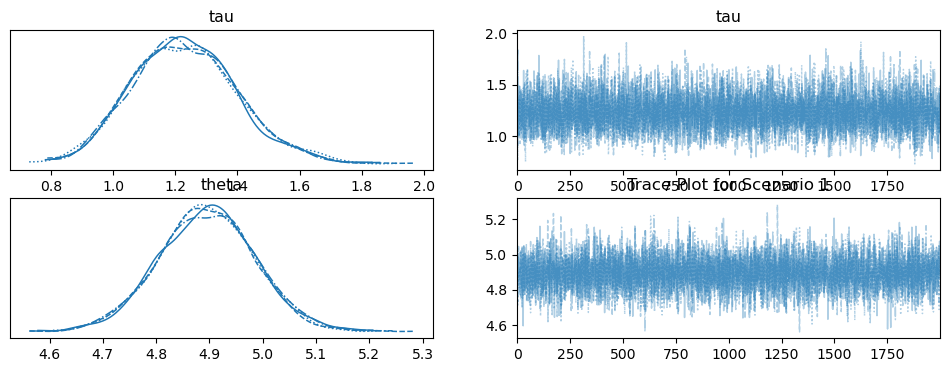

        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
tau    1.231  0.170     0.909      1.575      0.002    0.001    7392.0   
theta  4.895  0.091     4.714      5.070      0.001    0.001    7293.0   

       ess_tail  r_hat  
tau      5862.0    1.0  
theta    5956.0    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


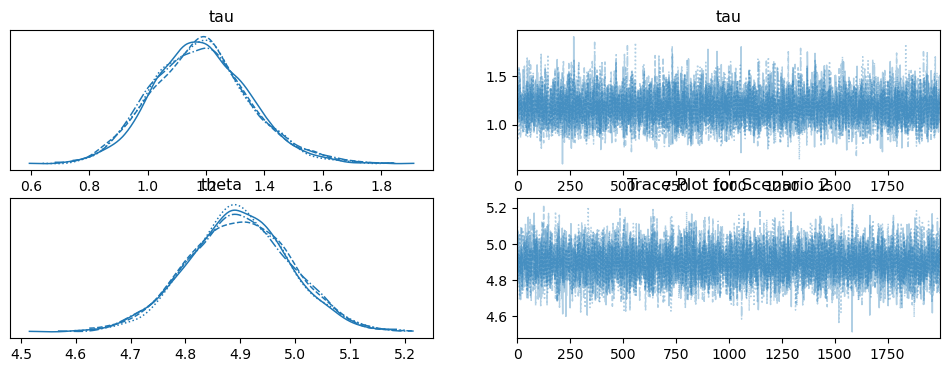

        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
tau    1.183  0.166     0.849      1.499      0.002    0.001    7955.0   
theta  4.897  0.093     4.715      5.077      0.001    0.001    8060.0   

       ess_tail  r_hat  
tau      5491.0    1.0  
theta    5464.0    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


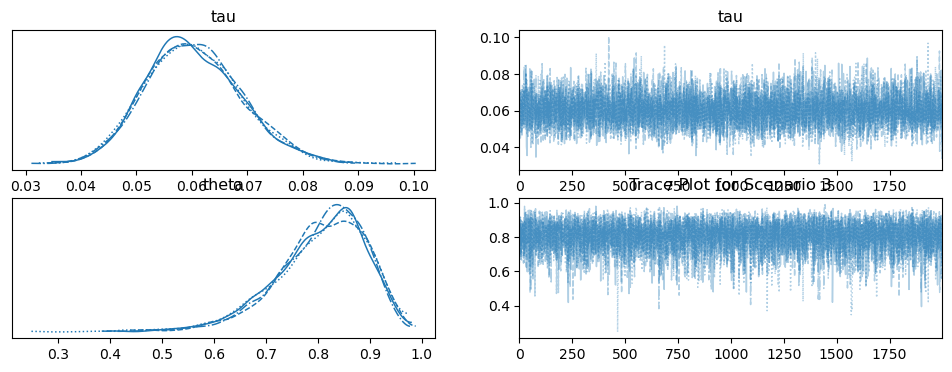

        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
tau    0.060  0.009     0.044      0.077      0.000    0.000    6789.0   
theta  0.806  0.088     0.637      0.959      0.001    0.001    6862.0   

       ess_tail  r_hat  
tau      5538.0    1.0  
theta    5809.0    1.0  


In [3]:
##Q2
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

# Set seed for reproducibility
np.random.seed(42)

# Sample parameters
true_theta = 5.0   # true mean
true_tau = 1.0     # true precision (1/variance)
n = 100            # sample size

# Generate sample data
data = np.random.normal(loc=true_theta, scale=1/np.sqrt(true_tau), size=n)

# Scenario 1: Normal prior for theta and Gamma prior for tau
with pm.Model() as model1:
    # Priors
    theta = pm.Normal('theta', mu=0, sigma=10)  # Normal prior for theta
    tau = pm.Gamma('tau', alpha=2, beta=1)       # Gamma prior for tau

    # Likelihood
    likelihood = pm.Normal('likelihood', mu=theta, tau=tau, observed=data)

    # Inference
    trace1 = pm.sample(2000, tune=1000, return_inferencedata=True)

# Diagnostic Assessment for Scenario 1
az.plot_trace(trace1)
plt.title('Trace Plot for Scenario 1')
plt.show()
print(az.summary(trace1, hdi_prob=0.95))

# Scenario 2: Non-Normal prior for theta and Non-Gamma prior for tau
with pm.Model() as model2:
    # Priors
    theta = pm.Uniform('theta', lower=0, upper=10)  # Uniform prior for theta
    tau = pm.InverseGamma('tau', alpha=2, beta=1)    # Inverse gamma prior for tau

    # Likelihood
    likelihood = pm.Normal('likelihood', mu=theta, tau=tau, observed=data)

    # Inference
    trace2 = pm.sample(2000, tune=1000, return_inferencedata=True)

# Diagnostic Assessment for Scenario 2
az.plot_trace(trace2)
plt.title('Trace Plot for Scenario 2')
plt.show()
print(az.summary(trace2, hdi_prob=0.95))

# Scenario 3: Different Non-Normal prior for theta and another Non-Gamma prior for tau
with pm.Model() as model3:
    # Priors
    theta = pm.Beta('theta', alpha=2, beta=5)  # Beta prior for theta
    tau = pm.LogNormal('tau', mu=0, sigma=1)    # Log-normal prior for tau

    # Likelihood
    likelihood = pm.Normal('likelihood', mu=theta, tau=tau, observed=data)

    # Inference
    trace3 = pm.sample(2000, tune=1000, return_inferencedata=True)

# Diagnostic Assessment for Scenario 3
az.plot_trace(trace3)
plt.title('Trace Plot for Scenario 3')
plt.show()
print(az.summary(trace3, hdi_prob=0.95))


# Q3:


Slice sampling is a way to draw samples from a probability distribution without needing to know the full distribution. Instead of trying to sample directly, we "slice" the distribution into horizontal sections. Here’s how it works:

1. You start with a function \( f(x) \) that represents your target distribution. This function is proportional to the probability you want to sample from. Think of it as the shape of the distribution curve you’re trying to work with.

2.  For a current point \( x \), you randomly select a height \( y \) between 0 and \( f(x) \). This height represents a horizontal slice under the curve.

3. You look for the section on the x-axis where the function \( f(x) \) is greater than your chosen height \( y \). You’ll identify the left and right boundaries of this interval.

4. You then randomly pick a new candidate point \( x' \) from this interval. If \( f(x') \) is greater than \( y \), congratulations! You’ve found a new sample. If not, you adjust your interval and try again.

5. **Repeat**: You keep repeating these steps, creating a chain of samples that relate to each other.


The Metropolis within Gibbs algorithm is a method for sampling from complex distributions. Sometimes, we can only find the full conditionals of the parameters we want to sample from up to a constant (which is tricky). In these cases, we can swap in slice sampling instead of using a standard Metropolis-Hastings step. Here’s how:

1. If you have a parameter \( \theta \) that depends on other variables. The full conditional distribution for \( \theta \) is what we want to sample from.

2. Yu define a function \( f(\theta) \) based on the full conditional distribution. This function is proportional to what you want to sample, but it doesn’t have to include the normalizing constant.

3. Choose a starting point \( \theta^{(0)} \). This is based on the current values of the other variables in your Gibbs sampler.

4. Randomly pick a height \( y \) from the interval \( [0, f(\theta^{(0)})] \). This height represents the slice you're going to work with.

5. Use the function `slice_f_at_y` to find a new value \( \theta^{(1)} \). You’ll find the interval where \( f(\theta) > y \) and sample from there until you get a valid sample.

6. Now replace old value of \( \theta \) with the new one \( \theta^{(1)} \) and continue sampling the next variable from its full conditional.

7. **Repeat the Process**: Keep repeating these steps for however many iterations you need for your Gibbs sampler.


- The curve we’re sampling beneath is \( f(x) \), which represents the probability density function of the distribution we want to sample from.
- The initial value \( \theta^{(0)} \) comes from the current state of other variables.
- You randomly select a height, find the right interval, and use slice sampling to draw a new value.



In [1]:
def slice_f_at_y(f, x, y, x_grid=np.linspace(0,1,51)):
    
    # find interval of grid points where f(x_grid) > y 
    # then extend the enterval so endpoints f(a)<y and f(b)<y 
    x_grid_delta = x_grid[1]-x_grid[0]
    a,b = x_grid[f(x_grid)>y][[0,-1]]+[-x_grid_delta,x_grid_delta]
    # a,b = x_grid[0,-1]  # make the interval all of x_grid
    
    x_ = a + stats.uniform().rvs()*(b-a)    
    if f(x_)>y:
        return x_,1  # in 1 try if f(x_)>y and "x_ is under f" 
    elif x_ < x:  # or if "x_ was above f on the left side of the interval" 
        x_l,x_r = x_,b
    else:
        x_l,x_r = a,x_  # or if "x_ was above f on the right side of the interval"
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = 2)  # try again with a reduced interval

def slice_f_at_y_(f, x, y, x_l=0, x_r=1, tot=1):
    
    x_ = x_l + stats.uniform().rvs()*(x_r-x_l)
    
    if f(x_)>y:
        return x_,tot
    elif x_ < x:
        x_l = x_
    else:
        x_r = x_
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = tot+1)


NameError: name 'np' is not defined

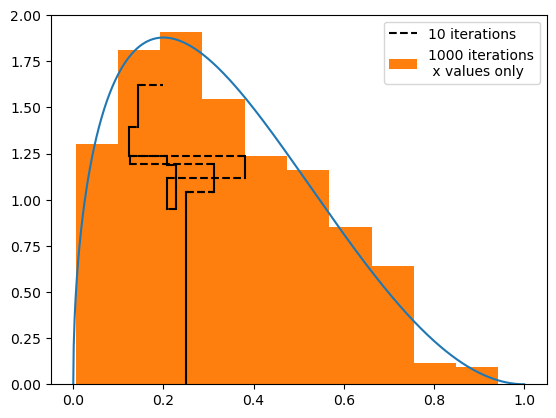

In [30]:
x_grid = np.linspace(0,1,1000)
f = lambda x: stats.beta(1.5,3).pdf(x)
plt.plot(x_grid, f(x_grid))
    
m = 1000
x = np.zeros([m+1,3])
x[:2,0] = 0.25

plot_trace = 10
for t in range(1,m):
    
    x[t,1] = stats.uniform().rvs()*f(x[t,0])
    if t < plot_trace:
        plt.plot([x[t,0]]*2, [x[t-1,1],x[t,1]], 'k')
    
    x[t+1,0],x[t+1,2] = slice_f_at_y(f, x[t,0], x[t,1])
    if t < plot_trace:
        if t==1:
            plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--', label=str(plot_trace)+ " iterations")
        plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--')
    
plt.hist(x[:,0], density=True, label=str(m)+" iterations\n x values only")
plt.legend();